In [2]:
import glob
# ^^^ pyforest auto-imports - don't write above this line
import pandas as pd
import numpy as np
import warnings
from pprint import pprint
from glob import glob

warnings.filterwarnings('ignore')

RELATIONSHIPS_FOLDER = '../metadata/relationships'
BBOX_FOLDER = '../metadata/bbox'
LABELS_FILE = '../metadata/class-descriptions-boxable.csv'

# Load the data:

In [57]:
relationship_dfs = [pd.read_csv(file_name) for file_name in glob(RELATIONSHIPS_FOLDER + '/*.csv')]
bbox_dfs = [pd.read_csv(file_name) for file_name in glob(BBOX_FOLDER + '/*.csv')]

In [58]:
relationship_df = relationship_dfs[0].append(relationship_dfs[1]).append(relationship_dfs[2])
bbox_df = bbox_dfs[0].append(bbox_dfs[1]).append(bbox_dfs[2])

In [60]:
relationship_df.shape

(3284282, 12)

In [63]:
bbox_df.shape

(15851536, 21)

# Clean the data:

In [66]:
# Remove 'is' relationship from the data.
relationship_df_final = relationship_df[relationship_df.RelationshipLabel != 'is']

In [68]:
# Remove images that don't have any labeled relationships.
bbox_df_final = bbox_df[bbox_df.ImageID.isin(relationship_df_final.ImageID.unique().tolist())]

In [170]:
labels_df = pd.read_csv(LABELS_FILE)
labels_dict = {label_id: label_name for label_id, label_name in zip(labels_df.LabelID.tolist(), labels_df.LabelName.tolist())}

def label_to_string(series):
    return series.map(labels_dict.get)

In [100]:
relationship_df_final['LabelName1'] = label_to_string(relationship_df_final['LabelName1'])
relationship_df_final['LabelName2'] = label_to_string(relationship_df_final['LabelName2'])
bbox_df_final['LabelName'] = label_to_string(bbox_df_final['LabelName'])

In [156]:
relationship_df_final = relationship_df_final.reset_index()

In [157]:
grouped_relationships = relationship_df_final.groupby(['LabelName1', 'LabelName2'])
relationship_keys = list(grouped_relationships.groups.keys())

In [171]:
# Get relationships that have equal labels.
# And reorder the columns for half of them.
relationships_to_fix = []
for idx, key in enumerate(relationship_keys):
    if key[::-1] in relationship_keys and key[0] != key[1]:
        relationships_to_fix.append(key)

i = 0
while i < len(relationships_to_fix):
    relationships_to_fix.remove(relationships_to_fix[i][::-1])
    i += 1

In [206]:
def swap_columns(df, columns, index):
    df.loc[index, columns] = df.loc[index, columns[::-1]].values

In [165]:
# Swap labelname1, and labelname2.
for group in relationships_to_fix:
    swap_columns(relationship_df_final, ['LabelName1', 'LabelName2'], grouped_relationships.get_group(group).index)

In [196]:
# Convert 'under' relationship to 'on' by swapping labelname1 and labelname2.
index = relationship_df_final[relationship_df_final.RelationshipLabel == 'under'].index
swap_columns(relationship_df_final, ['LabelName1', 'LabelName2'], index)
relationship_df_final.loc[index, 'RelationshipLabel'] = 'on'

In [223]:
labels_set = set(relationship_df.LabelName1.unique()).union(relationship_df.LabelName2.unique())

In [226]:
# Removing unnecessary labels from bbox_df
bbox_df_final = bbox_df_final[bbox_df_final.LabelName.isin(labels_set)]

In [257]:
# Removing unnecessary columns
relationship_df_final = relationship_df_final[relationship_df_final.columns.tolist()[1:]]
bbox_df_final = bbox_df_final[bbox_dfs[1].columns.tolist()[]]

# Checkpoint:

In [101]:
from datetime import datetime

In [381]:
date = str(datetime.now()).replace(' ', '_').replace(':', '-').split('.')[0]
relationship_df_final.to_csv(f'../checkpoints/relationships_modified_{date}.csv', index=False)
bbox_df_final.to_csv(f'../checkpoints/bbox_modified_{date}.csv', index=False)

# Load from checkpoint:

In [3]:
checkpoints = glob('../checkpoints/*.csv')

In [4]:
relationship_checkpoint = [checkpoint for checkpoint in checkpoints if 'relationships' in checkpoint][-1]
bbox_checkpoint = [checkpoint for checkpoint in checkpoints if 'bbox' in checkpoint][-1]

In [5]:
relationship_df = pd.read_csv(relationship_checkpoint)
bbox_df = pd.read_csv(bbox_checkpoint)

In [6]:
grouped_relationship_df = relationship_df.groupby('ImageID')
grouped_bbox_df = bbox_df.groupby('ImageID')

In [14]:
groups = relationship_df.groupby(['LabelName1', 'LabelName2']).groups.keys()

In [17]:
('Apple', 'qee') in groups

False

In [15]:
groups

dict_keys([('Apple', 'Christmas tree'), ('Apple', 'Countertop'), ('Apple', 'Cutting board'), ('Apple', 'Tree'), ('Artichoke', 'Cutting board'), ('Banana', 'Palm tree'), ('Banana', 'Tree'), ('Beer', 'Coffee table'), ('Beer', 'Desk'), ('Beer', 'Table'), ('Bell pepper', 'Countertop'), ('Bell pepper', 'Cutting board'), ('Bench', 'Dog'), ('Bottle', 'Beer'), ('Bottle', 'Candy'), ('Bottle', 'Cocktail'), ('Bottle', 'Coffee table'), ('Bottle', 'Desk'), ('Bottle', 'Juice'), ('Bottle', 'Orange'), ('Bottle', 'Table'), ('Bottle', 'Wine'), ('Bowl', 'Apple'), ('Bowl', 'Banana'), ('Bowl', 'Broccoli'), ('Bowl', 'Candy'), ('Bowl', 'Cucumber'), ('Bowl', 'Egg (Food)'), ('Bowl', 'Grapefruit'), ('Bowl', 'Ice cream'), ('Bowl', 'Mango'), ('Bowl', 'Orange'), ('Bowl', 'Pancake'), ('Bowl', 'Pasta'), ('Bowl', 'Peach'), ('Bowl', 'Pear'), ('Bowl', 'Pomegranate'), ('Bowl', 'Popcorn'), ('Bowl', 'Radish'), ('Bowl', 'Salad'), ('Bowl', 'Shrimp'), ('Bowl', 'Strawberry'), ('Bowl', 'Taco'), ('Bowl', 'Tomato'), ('Bowl', 'Zu

In [386]:
test_r = grouped_relationship_df.get_group('30ace30967aca271').reset_index()

In [387]:
test_b = grouped_bbox_df.get_group('30ace30967aca271').reset_index()

In [358]:
def get_box(bbox):
    return {
        'left': bbox[1],
        'top': bbox[3],
        'width': bbox[2] - bbox[1],
        'height': bbox[4] - bbox[3]
    }

In [317]:
def intersection_over_union(box_a, box_b):
    # Determine the coordinates of each of the two boxes
    xA = max(box_a['left'], box_b['left'])
    yA = max(box_a['top'], box_b['top'])
    xB = min(box_a['left'] + box_a['width'], box_b['left']+box_b['width'])
    yB = min(box_a['top'] + box_a['height'], box_b['top']+box_b['height'])

    # Calculate the area of the intersection area
    area_of_intersection = (xB - xA + 1) * (yB - yA + 1)

    # Calculate the area of both rectangles
    box_a_area = (box_a['width'] + 1) * (box_a['height'] + 1)
    box_b_area = (box_b['width'] + 1) * (box_b['height'] + 1)
    # Calculate the area of intersection divided by the area of union
    # Area of union = sum both areas less the area of intersection
    iou = area_of_intersection / float(box_a_area + box_b_area - area_of_intersection)

    # Return the score
    return iou

In [369]:
def exists(permutation, permutations):
    return any(permutation == p for p in permutations)

In [353]:
relationships = []
objects = []
for idx, r in test_r.iterrows():
    label_1 = [r.LabelName1, r.XMin1, r.XMax1, r.YMin1, r.YMax1]
    label_1 = label_1[:1] + [round(n, 8) for n in label_1[1:]]
    label_2 = [r.LabelName2, r.XMin2, r.XMax2, r.YMin2, r.YMax2]
    label_2 = label_2[:1] + [round(n, 8) for n in label_2[1:]]
    relationship = [label_1, label_2]
    relationships.append(relationship)
    
for idx, r in test_b.iterrows():
    object_ = [r.LabelName, r.XMin, r.XMax, r.YMin, r.YMax]
    object_ = object_[:1] + [round(n, 8) for n in object_[1:]]
    objects.append(object_)

In [344]:
test_r

,level_0,index,ImageID,LabelName1,LabelName2,XMin1,XMax1,YMin1,YMax1,XMin2,XMax2,YMin2,YMax2,RelationshipLabel
0,367907,27190,30ace30967aca271,Man,Sunglasses,0.012635,0.978339,0.007220,1.0,0.400722,0.534296,0.104693,0.160650,wears
1,367908,27191,30ace30967aca271,Man,Sunglasses,0.559567,1.000000,0.128159,1.0,0.649819,0.794224,0.198556,0.258123,wears
2,367909,27192,30ace30967aca271,Man,Glasses,0.012635,0.978339,0.007220,1.0,0.395307,0.534296,0.104693,0.160650,wears
3,367910,27193,30ace30967aca271,Man,Glasses,0.559567,1.000000,0.128159,1.0,0.648014,0.797834,0.205776,0.256318,wears


In [343]:
test_b

,index,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,IsGroupOf,IsDepiction,IsInside
0,916422,30ace30967aca271,xclick,Glasses,1,0.395307,0.534296,0.104693,0.158845,0,0,0,0,0
1,916423,30ace30967aca271,xclick,Glasses,1,0.649819,0.797834,0.205776,0.254513,0,0,0,0,0
2,916424,30ace30967aca271,xclick,Sunglasses,1,0.400722,0.534296,0.104693,0.158845,0,0,0,0,0
3,916425,30ace30967aca271,xclick,Sunglasses,1,0.651625,0.794224,0.198556,0.256318,0,0,0,0,0
4,916426,30ace30967aca271,xclick,Man,1,0.012635,0.978339,0.007220,1.000000,0,1,0,0,0
5,916427,30ace30967aca271,xclick,Man,1,0.561372,1.000000,0.128159,1.000000,1,1,0,0,0


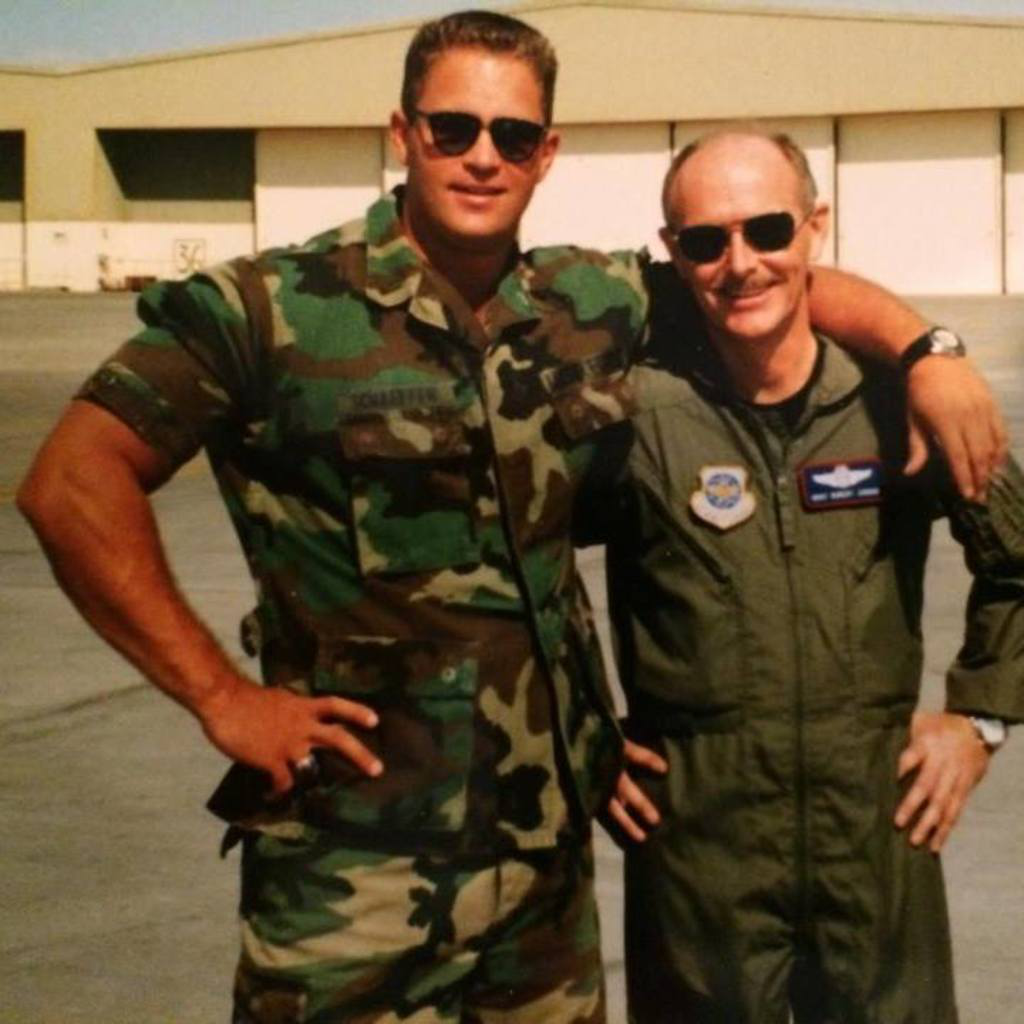

In [422]:
Image.open('dataset/validation/30ace30967aca271.jpg')

In [354]:
relationships

[[['Man', 0.012635, 0.978339, 0.00722, 1.0],
  ['Sunglasses', 0.400722, 0.534296, 0.104693, 0.16065]],
 [['Man', 0.559567, 1.0, 0.128159, 1.0],
  ['Sunglasses', 0.649819, 0.794224, 0.198556, 0.258123]],
 [['Man', 0.012635, 0.978339, 0.00722, 1.0],
  ['Glasses', 0.395307, 0.534296, 0.104693, 0.16065]],
 [['Man', 0.559567, 1.0, 0.128159, 1.0],
  ['Glasses', 0.648014, 0.797834, 0.205776, 0.256318]]]

In [355]:
objects

[['Glasses', 0.39530686, 0.53429604, 0.10469314, 0.15884477],
 ['Glasses', 0.6498195, 0.7978339, 0.20577617, 0.25451264],
 ['Sunglasses', 0.40072203, 0.53429604, 0.10469314, 0.15884477],
 ['Sunglasses', 0.65162456, 0.79422385, 0.19855596, 0.25631768],
 ['Man', 0.01263538, 0.9783394, 0.00722022, 1.0],
 ['Man', 0.56137186, 1.0, 0.12815884, 1.0]]

In [373]:
indices = [[] for _ in relationships]
for idx, relationship in enumerate(relationships):
    object_1 = relationship[0]
    object_2 = relationship[1]
    for jdx, object_ in enumerate(objects):
        box_a = get_box(object_1)
        box_b = get_box(object_2)
        box_c = get_box(object_)
        if object_1[0] == object_[0] and intersection_over_union(box_a, box_c) > 0.99:
            indices[idx].append(jdx)
        elif object_2[0] == object_[0] and intersection_over_union(box_b, box_c) > 0.99:
            indices[idx].append(jdx)
            
none_relationships = []
objects_count = len(objects)
for i in range(objects_count):
    for j in range(i+1, objects_count):
        if not exists([i, j], indices):
            none_relationships.append([i, j])

In [367]:
indices

[[2, 4], [3, 5], [0, 4], [1, 5]]

In [374]:
none_relationships

[[0, 1],
 [0, 2],
 [0, 3],
 [0, 5],
 [1, 2],
 [1, 3],
 [1, 4],
 [2, 3],
 [2, 5],
 [3, 4],
 [4, 5]]

In [388]:
relationship_df.head()

,ImageID,LabelName1,LabelName2,XMin1,XMax1,YMin1,YMax1,XMin2,XMax2,YMin2,YMax2,RelationshipLabel
0,9553b9608577b74b,Man,Sunglasses,0.023404,0.985106,0.038344,0.981595,0.238298,0.759574,0.349693,0.529141,wears
1,c9b609675b0db27e,Wine glass,Wine,0.276549,0.997788,0.000000,1.000000,0.272124,1.000000,0.000000,1.000000,contain
2,5813f39feb5218c3,Woman,Handbag,0.077088,0.897216,0.000000,1.000000,0.079229,0.740899,0.004688,0.860937,wears
3,5813f39feb5218c3,Girl,Handbag,0.308351,0.899358,0.000000,1.000000,0.079229,0.740899,0.004688,0.860937,wears
4,b2b742920d39272f,Man,Sunglasses,0.099278,1.000000,0.000000,1.000000,0.133574,0.916968,0.238267,0.590253,wears


In [396]:
test = relationship_df
for none_relationship in none_relationships:
    relationship = [objects[none_relationship[0]], objects[none_relationship[1]]]
    row = {
        'ImageID': '30ace30967aca271',
        'RelationshipLabel': None
    }
    for idx, object_ in enumerate(relationship):
        row[f'LabelName{idx+1}'] = object_[0]
        row[f'XMin{idx+1}'] = object_[1]        
        row[f'XMax{idx+1}'] = object_[2]        
        row[f'YMin{idx+1}'] = object_[3]        
        row[f'YMax{idx+1}'] = object_[4]
    test = test.append(row, ignore_index=True)

In [399]:
test.tail(20)

,ImageID,LabelName1,LabelName2,XMin1,XMax1,YMin1,YMax1,XMin2,XMax2,YMin2,YMax2,RelationshipLabel
367905,bdb8487ccbb6d988,Man,Sun hat,0.217119,0.855950,0.244131,0.960876,0.210856,0.630480,0.242567,0.505477,wears
367906,bdb8487ccbb6d988,Man,Glasses,0.217119,0.855950,0.244131,0.960876,0.336117,0.544885,0.359937,0.414710,wears
367907,30ace30967aca271,Man,Sunglasses,0.012635,0.978339,0.007220,1.000000,0.400722,0.534296,0.104693,0.160650,wears
367908,30ace30967aca271,Man,Sunglasses,0.559567,1.000000,0.128159,1.000000,0.649819,0.794224,0.198556,0.258123,wears
367909,30ace30967aca271,Man,Glasses,0.012635,0.978339,0.007220,1.000000,0.395307,0.534296,0.104693,0.160650,wears
367910,30ace30967aca271,Man,Glasses,0.559567,1.000000,0.128159,1.000000,0.648014,0.797834,0.205776,0.256318,wears
367911,da141ae39195c141,Man,Paddle,0.252212,0.337758,0.431416,0.732301,0.280236,0.438053,0.491150,0.719027,holds
367912,a071e97acf21b867,Man,Glasses,0.168869,0.922173,0.039911,0.995565,0.452276,0.624082,0.164080,0.303769,wears
367913,c8acead6ebdd6dd8,Man,Skateboard,0.142329,0.826248,0.054674,0.885362,0.353050,0.632163,0.587302,0.899471,skateboard
367914,30ace30967aca271,Glasses,Glasses,0.395307,0.534296,0.104693,0.158845,0.649819,0.797834,0.205776,0.254513,None


In [410]:
b_keys = set(grouped_bbox_df.groups.keys())

In [431]:
relationship_df.sample(10)

,ImageID,LabelName1,LabelName2,XMin1,XMax1,YMin1,YMax1,XMin2,XMax2,YMin2,YMax2,RelationshipLabel
162151,3f83e82072f03dc9,Chair,Table,0.809375,0.876250,0.320000,0.443333,0.213750,0.915000,0.461111,0.998889,at
347483,6a731463bb6718e6,Wine glass,Wine,0.276875,0.357500,0.668333,0.930833,0.281875,0.347500,0.763333,0.822500,contain
125300,b5767c6369490a9a,Wine glass,Table,0.203750,0.362500,0.137500,0.689167,0.000000,0.999375,0.424167,0.999167,on
307369,bbc9e91fc1297540,Woman,Car,0.375000,0.646484,0.330729,0.898438,0.000000,0.998047,0.601563,0.997396,ride
330347,6a897e808e85eba5,Woman,Table,0.488750,0.957500,0.244841,0.999062,0.000000,0.526875,0.804878,0.997186,at
199919,d2ade5a686749a22,Woman,Bus,0.086875,0.387500,0.524390,1.000000,0.000000,0.999375,0.000000,0.999062,inside_of
307237,ae8fcac607c5fc14,Man,Table,0.354375,0.453125,0.401130,0.685499,0.313750,0.388125,0.518832,0.738230,at
217417,e490ec11cc1d8fda,Man,Chair,0.599375,0.953125,0.081006,0.999069,0.553125,0.999375,0.497207,0.999069,on
278718,75aae0af5d75f79f,Woman,Sun hat,0.553125,0.771875,0.426724,0.996767,0.613125,0.776250,0.433190,0.620690,wears
186116,12e63f39ccc6492b,Woman,Table,0.179375,0.533750,0.363333,0.976667,0.027500,0.921875,0.607500,0.991667,at
